In [33]:
# 基本ライブラリ
import pandas as pd
import pandas.io.sql as psql
import numpy as np
import numpy.random as rd
import gc
import multiprocessing as mp
import os
import sys
import pickle
from collections import defaultdict
from glob import glob
import math
from datetime import datetime as dt
from pathlib import Path
import scipy.stats as st
import re
import shutil
from tqdm import tqdm_notebook as tqdm
import datetime
ts_conv = np.vectorize(datetime.datetime.fromtimestamp) # 秒ut(10桁) ⇒ 日付

# グラフ描画系
import matplotlib
from matplotlib import font_manager
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import rc

from matplotlib import animation as ani
from IPython.display import Image

plt.rcParams["patch.force_edgecolor"] = True
#rc('text', usetex=True)
from IPython.display import display # Allows the use of display() for DataFrames
import seaborn as sns
sns.set(style="whitegrid", palette="muted", color_codes=True)
sns.set_style("whitegrid", {'grid.linestyle': '--'})
red = sns.xkcd_rgb["light red"]
green = sns.xkcd_rgb["medium green"]
blue = sns.xkcd_rgb["denim blue"]

#カラム内の文字数。デフォルトは50
pd.set_option("display.max_colwidth", 100)

#行数
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
#
pd.options.display.float_format = '{:,.10f}'.format

%matplotlib inline

In [5]:

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedKFold

from sklearn import metrics
import json

import warnings
warnings.filterwarnings("ignore")


sys.path.append('..')
from lib.line_notif import send_message
#from lib.utils import matrics_rotate
from lib.utils import reduce_mem_usage, current_time, unpickle, to_pickle
from lib.utils import one_hot_encoder, apply_agg, multi_combine_categorical_feature
from lib.utils import import_data, get_split_indexer 

In [6]:


def group_mean_log_mae(y_true, y_pred, types, floor=1e-9):
    """
    Fast metric computation for this competition: https://www.kaggle.com/c/champs-scalar-coupling
    Code is from this kernel: https://www.kaggle.com/uberkinder/efficient-metric
    """
    maes = (y_true - y_pred).abs().groupby(types).mean()
    return np.log(maes.map(lambda x: max(x, floor))).mean()

In [7]:
train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')
structures = pd.read_csv('../input/structures.csv')

In [11]:
np.exp(-2.282), np.exp(-2.286), np.exp(-2.208)

(0.10207984273420903, 0.1016723389142504, 0.10992026936018012)

In [19]:
c1, c2, c3 = np.exp(-2.282), np.exp(-2.286), np.exp(-2.208)
sum_c = np.sum([c1, c2, c3])
print(c1, c2, c3)
print(c1/sum_c, c2/sum_c, c3/sum_c)
print((c1)**-1, (c2)**-1, (c3)**-1)

0.10207984273420903 0.1016723389142504 0.10992026936018012
0.32543451745909757 0.32413537939756787 0.35043010314333456
9.796253336750878 9.83551682472252 9.0975031795388


In [20]:
c1, c2, c3 = np.exp(-2.282), np.exp(-2.286), np.exp(-2.208)
sum_c = np.sum([1/c1, 1/c2, 1/c3])

print(c1, c2, c3)
print(1/c1/sum_c, 1/c2/sum_c, 1/c3/sum_c)

0.10207984273420903 0.1016723389142504 0.10992026936018012
0.3409850719324088 0.34235174374152805 0.3166631843260632


In [ ]:
c1, c2, c3 =

In [28]:
sub1 = pd.read_csv("../submit/ensemble/ensemble_lgb101_nn5fold_8vs1.csv")  # LB: -2.282
sub2 = pd.read_csv("../submit/v003_104/blending_v003_104_21seeds.csv") # LB: -2.286
sub3 = pd.read_csv("../submit/v003_105/blending_v003_105_19seeds.csv") # LB: -2.208

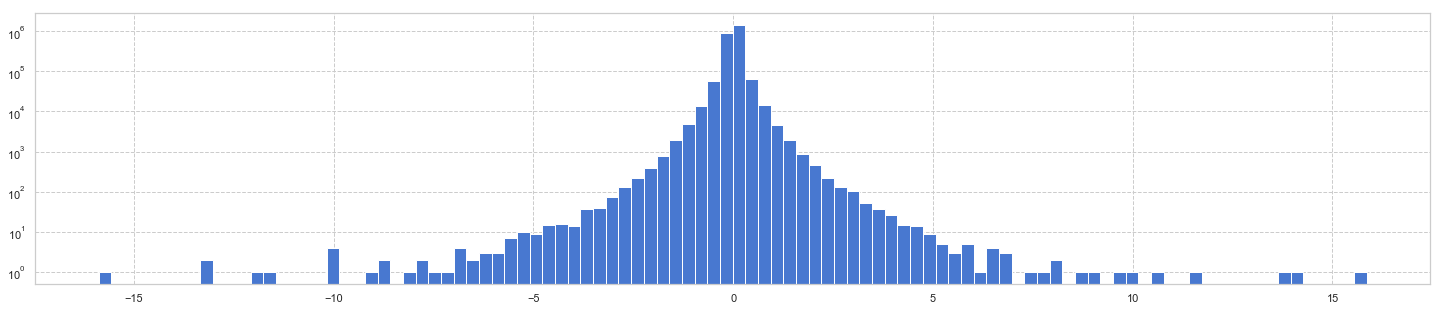

In [29]:
diff_df = sub1 - sub2
plt.figure(figsize=(25,5))
ax = plt.subplot(111)
diff_df.scalar_coupling_constant.hist(bins=100, ax=ax)
plt.yscale("log")

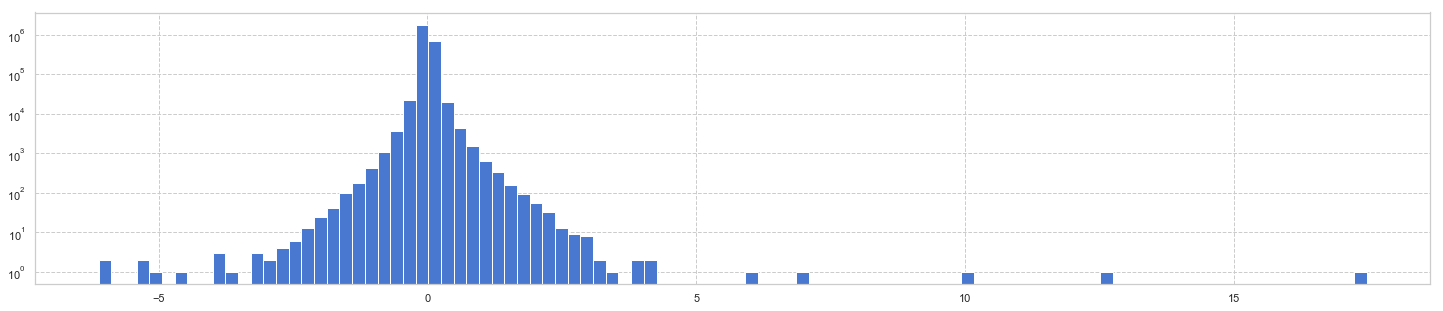

In [30]:
diff_df = sub2 - sub3
plt.figure(figsize=(25,5))
ax = plt.subplot(111)
diff_df.scalar_coupling_constant.hist(bins=100, ax=ax)
plt.yscale("log")

In [31]:
sampled_id = sub1.sample(frac=0.1).id.values

In [34]:
pd.concat([sub1.set_index("id").loc[sampled_id].scalar_coupling_constant, 
            sub2.set_index("id").loc[sampled_id].scalar_coupling_constant, 
            sub3.set_index("id").loc[sampled_id].scalar_coupling_constant],axis=1).corr()

,scalar_coupling_constant,scalar_coupling_constant,scalar_coupling_constant
scalar_coupling_constant,1.0000000000,0.9999832369,0.9999805017
scalar_coupling_constant,0.9999832369,1.0000000000,0.9999967512
scalar_coupling_constant,0.9999805017,0.9999967512,1.0000000000


In [23]:
sub1.head()

,id,scalar_coupling_constant
0,4658147,17.57451
1,4658148,184.99951
2,4658149,3.64457
3,4658150,182.96809
4,4658151,17.39610


In [24]:
sub2.head()

,id,scalar_coupling_constant
0,4658147,17.53979
1,4658148,193.21794
2,4658149,4.38341
3,4658150,192.83359
4,4658151,8.46664


In [25]:
sub3.head()

,id,scalar_coupling_constant
0,4658147,17.32225
1,4658148,193.67446
2,4658149,3.29299
3,4658150,193.43636
4,4658151,9.35585


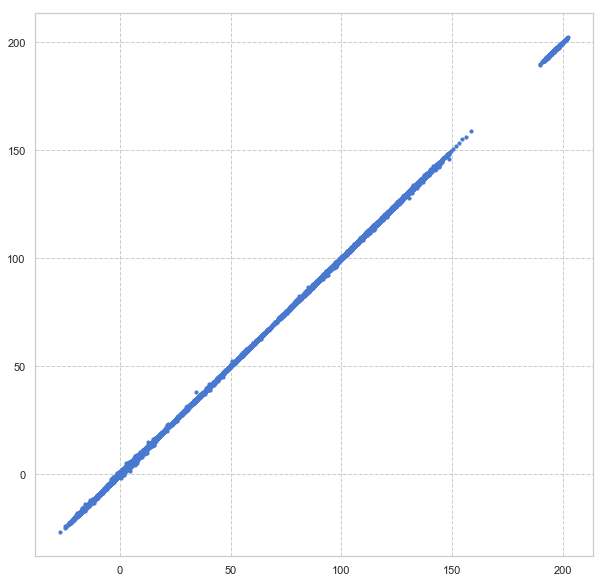

In [26]:
plt.figure(figsize=(10,10))
plt.scatter(x=sub2.set_index("id").loc[sampled_id].scalar_coupling_constant, 
            y=sub3.set_index("id").loc[sampled_id].scalar_coupling_constant, s=10)

In [13]:
!mkdir ../submit/ensemble

mkdir: ../submit/ensemble: File exists


In [43]:
preds1 = sub1.scalar_coupling_constant.values
preds2 = sub2.scalar_coupling_constant.values
preds3 = sub3.scalar_coupling_constant.values

In [44]:
sub = pd.read_csv('../input/sample_submission.csv')
w1 = 5
w2 = 5
w3 = 1
sub['scalar_coupling_constant'] = (w1*preds1 + w2*preds2 + w3*preds3) / (w1+w2+w3)
#sub['scalar_coupling_constant'] = (w1*preds1 + w2*preds2 ) / (w1+w2)
sub.to_csv(f'../submit/ensemble/ensemble_-2.282_-2.286_-2.208_{w1}vs{w2}vs{w3}.csv', index=False)
print(sub.head())

        id  scalar_coupling_constant
0  4658147             17.5357989487
1  4658148            189.5237907654
2  4658149              3.9484430321
3  4658150            188.4040699540
4  4658151             12.6063245381


In [45]:
sub.head()

,id,scalar_coupling_constant
0,4658147,17.5357989487
1,4658148,189.5237907654
2,4658149,3.9484430321
3,4658150,188.4040699540
4,4658151,12.6063245381


,id,scalar_coupling_constant
0,4658147,17.5101725906
1,4658148,190.0218715449
2,4658149,3.8697881511
3,4658150,189.0079446357
4,4658151,12.2162670776


,id,scalar_coupling_constant
0,4658147,17.55715
1,4658148,189.10872
2,4658149,4.01399
3,4658150,187.90084
4,4658151,12.93137


,id,scalar_coupling_constant
0,4658147,17.56154
1,4658148,182.10280
2,4658149,3.46695
3,4658150,179.86937
4,4658151,16.81483


In [46]:
ls -ltr ../submit/ensemble/

total 4831736
-rw-r--r--  1 kenichi.matsui  1522739515  67160057  6 16 16:56 ensemble_v003_007__009_1vs2_.csv
-rw-r--r--  1 kenichi.matsui  1522739515  67160057  6 16 16:57 ensemble_v003_009__015_2vs1.csv
-rw-r--r--  1 kenichi.matsui  1522739515  67157799  6 16 19:29 ensemble_v003_009__015__016_3vs1vs1.csv
-rw-r--r--  1 kenichi.matsui  1522739515  67158249  6 21 10:09 ensemble_v003_009__017__019_3vs1vs1.csv
-rw-r--r--  1 kenichi.matsui  1522739515  67158249  6 21 10:09 ensemble_v003_009__017__019_1vs1.csv
-rw-r--r--  1 kenichi.matsui  1522739515  67161117  6 21 16:33 ensemble_v003_017__019__021_2vs2vs1.csv
-rw-r--r--  1 kenichi.matsui  1522739515  67160867  6 22 11:38 ensemble_v003_017__019__023__021__022.csv
-rw-r--r--  1 kenichi.matsui  1522739515  67160621  6 23 02:06 ensemble_v003_017__019__023__021__022_1vs1vs1vs4.csv
-rw-r--r--  1 kenichi.matsui  1522739515  67163538  6 28 08:47 ensemble_v003_024__031_24vs12.csv
-rw-r--r--  1 kenichi.matsui  1522739515  67162555  6 29 02:54 ensem

In [47]:
# !kaggle competitions submit -c champs-scalar-coupling -f ../submit/ensemble/ensemble_-2.282_-2.286_-2.208_5vs5vs1.csv -m "blending_042.ipynb"

100%|██████████████████████████████████████| 64.1M/64.1M [00:30<00:00, 2.22MB/s]
Successfully submitted to Predicting Molecular Properties

In [36]:
oof = pd.read_csv("../submit/v003_010/tmp_oof_7.csv", index_col=0)

In [39]:
oof_tmp.head()

,ind,type,oof,target
0,0,0,84.57668,84.80000
1,1,3,-11.21870,-11.26000
2,2,3,-11.21358,-11.26000
3,3,3,-11.20236,-11.26000
4,4,0,85.30134,84.80000


In [42]:
train.head()

,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant
0,0,dsgdb9nsd_000001,1,0,1JHC,84.80760
1,1,dsgdb9nsd_000001,1,2,2JHH,-11.25700
2,2,dsgdb9nsd_000001,1,3,2JHH,-11.25480
3,3,dsgdb9nsd_000001,1,4,2JHH,-11.25430
4,4,dsgdb9nsd_000001,2,0,1JHC,84.80740


In [44]:
mean_log_mae = group_mean_log_mae(train.scalar_coupling_constant, oof_tmp.target, train.type)

In [45]:
mean_log_mae

-6.485634093498289

In [46]:
sub_temp = pd.read_csv("../submit/v003_010/tmp_sub_7.csv")

In [47]:
sub_temp.head()

,Unnamed: 0,ind,type,prediction
0,0,0,2,10.48430
1,1,1,0,183.06382
2,2,2,6,1.54571
3,3,3,0,180.99084
4,4,4,2,8.76352


In [ ]:
DATA_VERSION = "v003"
TRIAL_NO = "010"
sub = pd.read_csv('../input/sample_submission.csv')
sub['scalar_coupling_constant'] = sub_temp['prediction']
sub.to_csv(f'../submit/v003_010/submission_t_{DATA_VERSION}_{TRIAL_NO}.csv', index=False)
print(sub.head())

In [ ]:
# !kaggle competitions submit -c champs-scalar-coupling -f ../submit/v003_010/submission_t_v003_010.csv -m "augmentation"

In [13]:
save_path = Path("../processed/v003")
train = unpickle(save_path/f"train_concat_v003_v003_009.pkl", )
test = unpickle(save_path/f"test_concat_v003_v003_009.pkl", )

augmented_train = unpickle(save_path/f"augmented_train_v001.pkl", ).drop(["Unnamed: 0_x", "Unnamed: 0_y"], axis=1)

In [4]:
train.head().T

,0,1,2,3,4
id,0,1,2,3,4
molecule_name,dsgdb9nsd_000001,dsgdb9nsd_000001,dsgdb9nsd_000001,dsgdb9nsd_000001,dsgdb9nsd_000001
atom_index_0,1,1,1,1,2
atom_index_1,0,2,3,4,0
type,0,3,3,3,0
scalar_coupling_constant,84.81250,-11.25781,-11.25781,-11.25781,84.81250
fc,83.00000,-11.03125,-11.03125,-11.03125,83.00000
sd,0.25464,0.35303,0.35303,0.35303,0.25464
pso,1.25879,2.85742,2.85938,2.85938,1.25879
dso,0.27197,-3.43359,-3.43359,-3.43359,0.27197


In [5]:
train.tail()

,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant,fc,sd,pso,dso,atom_0,x_0,y_0,z_0,atom_1,x_1,y_1,z_1,dist,dist_x,dist_y,dist_z,type_0,abs_dist,dist_xy,abs_dist_xy,dist_xz,abs_dist_xz,dist_yz,abs_dist_yz,C,F,H,N,O,molecule_couples,molecule_dist_mean,molecule_dist_min,molecule_dist_max,atom_0_couples_count,atom_1_couples_count,molecule_atom_index_0_x_1_std,molecule_atom_index_0_y_1_mean,molecule_atom_index_0_y_1_mean_diff,molecule_atom_index_0_y_1_mean_div,molecule_atom_index_0_y_1_max,molecule_atom_index_0_y_1_max_diff,molecule_atom_index_0_y_1_std,molecule_atom_index_0_z_1_std,molecule_atom_index_0_dist_mean,molecule_atom_index_0_dist_mean_diff,molecule_atom_index_0_dist_mean_div,molecule_atom_index_0_dist_max,molecule_atom_index_0_dist_max_diff,molecule_atom_index_0_dist_max_div,molecule_atom_index_0_dist_min,molecule_atom_index_0_dist_min_diff,molecule_atom_index_0_dist_min_div,molecule_atom_index_0_dist_std,molecule_atom_index_0_dist_std_diff,molecule_atom_index_0_dist_std_div,molecule_atom_index_1_dist_mean,molecule_atom_index_1_dist_mean_diff,molecule_atom_index_1_dist_mean_div,molecule_atom_index_1_dist_max,molecule_atom_index_1_dist_max_diff,molecule_atom_index_1_dist_max_div,molecule_atom_index_1_dist_min,molecule_atom_index_1_dist_min_diff,molecule_atom_index_1_dist_min_div,molecule_atom_index_1_dist_std,molecule_atom_index_1_dist_std_diff,molecule_atom_index_1_dist_std_div,molecule_atom_1_dist_mean,molecule_atom_1_dist_min,molecule_atom_1_dist_min_diff,molecule_atom_1_dist_min_div,molecule_atom_1_dist_std,molecule_atom_1_dist_std_diff,molecule_type_0_dist_std,molecule_type_0_dist_std_diff,molecule_type_dist_mean,molecule_type_dist_mean_diff,molecule_type_dist_mean_div,molecule_type_dist_max,molecule_type_dist_min,molecule_type_dist_std,molecule_type_dist_std_diff,f004:angle,f004:angle_abs,f006:dist_origin_mean,f006:mass_0,f006:mass_1,f006:dist_from_origin_0,f006:dist_from_origin_1,Angle,Torsion,cos2T,cosT,sp,a1_degree,a1_hybridization,a1_inring,a1_inring3,a1_inring4,a1_inring5,a1_inring6,a1_inring7,a1_inring8,a1_nb_h,a1_nb_o,a1_nb_c,a1_nb_n,a1_nb_na,a0_nb_degree,a0_nb_hybridization,a0_nb_inring,a0_nb_inring3,a0_nb_inring4,a0_nb_inring5,a0_nb_inring6,a0_nb_inring7,a0_nb_inring8,a0_nb_nb_h,a0_nb_nb_o,a0_nb_nb_c,a0_nb_nb_n,a0_nb_nb_na,x_a0_nb,y_a0_nb,z_a0_nb,a1_nb_degree,a1_nb_hybridization,a1_nb_inring,a1_nb_inring3,a1_nb_inring4,a1_nb_inring5,a1_nb_inring6,a1_nb_inring7,a1_nb_inring8,a1_nb_nb_h,a1_nb_nb_o,a1_nb_nb_c,a1_nb_nb_n,a1_nb_nb_na,x_a1_nb,y_a1_nb,z_a1_nb,dist_to_type_mean,eem_0,mmff94_0,gasteiger_0,qeq_0,qtpie_0,eem2015ha_0,eem2015hm_0,eem2015hn_0,eem2015ba_0,eem2015bm_0,eem2015bn_0,eem_1,mmff94_1,gasteiger_1,qeq_1,qtpie_1,eem2015ha_1,eem2015hm_1,eem2015hn_1,eem2015ba_1,eem2015bm_1,eem2015bn_1
4658142,4658142,dsgdb9nsd_133884,17,4,2,3.54297,3.58594,0.01974,0.15051,-0.21326,H,1.12695,-1.34863,-1.93359,C,1.62988,-0.74707,0.23523,2.30664,0.25342,0.36182,4.70312,2,3.27344,0.78418,1.10449,2.22656,2.67188,2.25000,2.77148,8,0,9,1,0,78,2.60938,1.08105,3.60156,8,7,1.07520,-0.24634,0.50098,0.32972,0.74707,1.49414,0.81348,0.75586,2.69336,0.38599,1.16699,3.49609,1.18848,1.51562,1.08105,-1.22559,0.46875,0.84521,-1.46094,0.36646,2.37109,0.06525,1.02832,3.24414,0.93701,1.40625,1.08301,-1.22266,0.46973,0.73486,-1.57129,0.31860,2.62500,1.08105,-1.22559,0.46875,0.79395,-1.51270,0.13599,-2.16992,2.27539,-0.03162,0.98633,2.31250,2.20898,0.03720,-2.26953,0.18005,0.18005,2.04102,1,12,2.60352,1.76367,122.93750,nan,nan,nan,nan,4,4,1,1,0,1,0,0,0,1,0,3,0,0,4,4,1,1,0,1,0,0,0,1,0,3,0,0,0.78760,-0.84033,-1.04199,1,1,0,0,0,0,0,0,0,0,0,1,0,0,2.58203,-1.25977,0.29346,1.05273,0.12457,0.09998,0.06555,-0.16809,0.12512,0.01929,0.19202,0.16003,0.03342,0.19604,0.17358,-0.09991,-0.19495,-0.05667,-0.26562,0.29980,0.00478,-0.17371,-0.13464,-0.01332,-0.18469,-0.15051
4658143,4658143,dsgdb9nsd_133884,17,5,5,0.56885,0.67480,-0.00727,0.30518,-0.40332,H,1.12695,-1.34863,-1.93359,C,1.41602,0.62061,0.93896,3.49609,0.08374,3.87891,8.

In [14]:
train["id"].max()+1

4658147

In [6]:
augmented_train['id']+=4658147

In [7]:
augmented_train.head()

,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant,fc,sd,pso,dso,atom_0,x_0,y_0,z_0,atom_1,x_1,y_1,z_1,dist,dist_x,dist_y,dist_z,type_0,abs_dist,dist_xy,abs_dist_xy,dist_xz,abs_dist_xz,dist_yz,abs_dist_yz,C,F,H,N,O,molecule_couples,molecule_dist_mean,molecule_dist_min,molecule_dist_max,atom_0_couples_count,atom_1_couples_count,molecule_atom_index_0_x_1_std,molecule_atom_index_0_y_1_mean,molecule_atom_index_0_y_1_mean_diff,molecule_atom_index_0_y_1_mean_div,molecule_atom_index_0_y_1_max,molecule_atom_index_0_y_1_max_diff,molecule_atom_index_0_y_1_std,molecule_atom_index_0_z_1_std,molecule_atom_index_0_dist_mean,molecule_atom_index_0_dist_mean_diff,molecule_atom_index_0_dist_mean_div,molecule_atom_index_0_dist_max,molecule_atom_index_0_dist_max_diff,molecule_atom_index_0_dist_max_div,molecule_atom_index_0_dist_min,molecule_atom_index_0_dist_min_diff,molecule_atom_index_0_dist_min_div,molecule_atom_index_0_dist_std,molecule_atom_index_0_dist_std_diff,molecule_atom_index_0_dist_std_div,molecule_atom_index_1_dist_mean,molecule_atom_index_1_dist_mean_diff,molecule_atom_index_1_dist_mean_div,molecule_atom_index_1_dist_max,molecule_atom_index_1_dist_max_diff,molecule_atom_index_1_dist_max_div,molecule_atom_index_1_dist_min,molecule_atom_index_1_dist_min_diff,molecule_atom_index_1_dist_min_div,molecule_atom_index_1_dist_std,molecule_atom_index_1_dist_std_diff,molecule_atom_index_1_dist_std_div,molecule_atom_1_dist_mean,molecule_atom_1_dist_min,molecule_atom_1_dist_min_diff,molecule_atom_1_dist_min_div,molecule_atom_1_dist_std,molecule_atom_1_dist_std_diff,molecule_type_0_dist_std,molecule_type_0_dist_std_diff,molecule_type_dist_mean,molecule_type_dist_mean_diff,molecule_type_dist_mean_div,molecule_type_dist_max,molecule_type_dist_min,molecule_type_dist_std,molecule_type_dist_std_diff,f004:angle,f004:angle_abs,f006:dist_origin_mean,f006:mass_0,f006:mass_1,f006:dist_from_origin_0,f006:dist_from_origin_1,Angle,Torsion,cos2T,cosT,sp,a1_degree,a1_hybridization,a1_inring,a1_inring3,a1_inring4,a1_inring5,a1_inring6,a1_inring7,a1_inring8,a1_nb_h,a1_nb_o,a1_nb_c,a1_nb_n,a1_nb_na,a0_nb_degree,a0_nb_hybridization,a0_nb_inring,a0_nb_inring3,a0_nb_inring4,a0_nb_inring5,a0_nb_inring6,a0_nb_inring7,a0_nb_inring8,a0_nb_nb_h,a0_nb_nb_o,a0_nb_nb_c,a0_nb_nb_n,a0_nb_nb_na,x_a0_nb,y_a0_nb,z_a0_nb,a1_nb_degree,a1_nb_hybridization,a1_nb_inring,a1_nb_inring3,a1_nb_inring4,a1_nb_inring5,a1_nb_inring6,a1_nb_inring7,a1_nb_inring8,a1_nb_nb_h,a1_nb_nb_o,a1_nb_nb_c,a1_nb_nb_n,a1_nb_nb_na,x_a1_nb,y_a1_nb,z_a1_nb,dist_to_type_mean,eem_0,mmff94_0,gasteiger_0,qeq_0,qtpie_0,eem2015ha_0,eem2015hm_0,eem2015hn_0,eem2015ba_0,eem2015bm_0,eem2015bn_0,eem_1,mmff94_1,gasteiger_1,qeq_1,qtpie_1,eem2015ha_1,eem2015hm_1,eem2015hn_1,eem2015ba_1,eem2015bm_1,eem2015bn_1
0,4658147,dsgdb9nsd_000001,1,0,1JHC,84.81250,83.00000,0.25464,1.25879,0.27197,H,-0.00397,0.00380,-0.00384,C,0.85400,-0.18323,0.64502,1.09180,0.73633,0.03497,0.42114,1,1.69434,0.87842,1.04492,1.07617,1.50684,0.67529,0.83594,1,0,4,0,0,10,1.50684,1.09180,1.78320,4,4,0.47241,-0.22998,-0.04672,1.25512,0.62061,0.80371,0.71777,0.59521,1.61035,0.51855,1.47461,1.78320,0.69141,1.63281,1.09180,0.00000,1.00000,0.34570,-0.74658,0.31641,1.09180,-0.00000,1.00000,1.09180,0.00000,1.00000,1.09180,-0.00001,1.00000,0.00000,-1.09180,0.00000,1.09180,1.09180,-0.00001,1.00000,0.00000,-1.09180,0.00000,-1.09180,1.09180,-0.00000,1.00000,1.09180,1.09180,0.00000,-1.09180,0.46973,0.46973,0.87354,1,12,1.09180,0.00000,nan,nan,nan,nan,3.00000,4,4,0,0,0,0,0,0,0,4,0,0,0,0,4,4,0,0,0,0,0,0,0,4,0,0,0,0,-0.01270,1.08594,0.00800,1,1,0,0,0,0,0,0,0,0,0,1,0,0,-0.52393,1.43750,0.90625,0.99902,0.16113,0.00000,0.01939,-0.81299,0.77344,-0.00365,0.20325,0.19629,0.01683,0.20154,0.21277,-0.64453,0.00000,-0.07758,3.25195,-3.09375,0.01460,-0.81299,-0.78516,-0.06732,-0.80615,-0.85107
1,4658148,dsgdb9nsd_000001,1,2,2JHH,-11.25781,-11.03125,0.35303,2.85742,-3.43359,H,-0.00397,0.00380,-0.00384,H,0.93701,0.62061,1.37988,1.78320,0.88574,0.38062,1.91309,

In [8]:
augmented_train.tail()

,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant,fc,sd,pso,dso,atom_0,x_0,y_0,z_0,atom_1,x_1,y_1,z_1,dist,dist_x,dist_y,dist_z,type_0,abs_dist,dist_xy,abs_dist_xy,dist_xz,abs_dist_xz,dist_yz,abs_dist_yz,C,F,H,N,O,molecule_couples,molecule_dist_mean,molecule_dist_min,molecule_dist_max,atom_0_couples_count,atom_1_couples_count,molecule_atom_index_0_x_1_std,molecule_atom_index_0_y_1_mean,molecule_atom_index_0_y_1_mean_diff,molecule_atom_index_0_y_1_mean_div,molecule_atom_index_0_y_1_max,molecule_atom_index_0_y_1_max_diff,molecule_atom_index_0_y_1_std,molecule_atom_index_0_z_1_std,molecule_atom_index_0_dist_mean,molecule_atom_index_0_dist_mean_diff,molecule_atom_index_0_dist_mean_div,molecule_atom_index_0_dist_max,molecule_atom_index_0_dist_max_diff,molecule_atom_index_0_dist_max_div,molecule_atom_index_0_dist_min,molecule_atom_index_0_dist_min_diff,molecule_atom_index_0_dist_min_div,molecule_atom_index_0_dist_std,molecule_atom_index_0_dist_std_diff,molecule_atom_index_0_dist_std_div,molecule_atom_index_1_dist_mean,molecule_atom_index_1_dist_mean_diff,molecule_atom_index_1_dist_mean_div,molecule_atom_index_1_dist_max,molecule_atom_index_1_dist_max_diff,molecule_atom_index_1_dist_max_div,molecule_atom_index_1_dist_min,molecule_atom_index_1_dist_min_diff,molecule_atom_index_1_dist_min_div,molecule_atom_index_1_dist_std,molecule_atom_index_1_dist_std_diff,molecule_atom_index_1_dist_std_div,molecule_atom_1_dist_mean,molecule_atom_1_dist_min,molecule_atom_1_dist_min_diff,molecule_atom_1_dist_min_div,molecule_atom_1_dist_std,molecule_atom_1_dist_std_diff,molecule_type_0_dist_std,molecule_type_0_dist_std_diff,molecule_type_dist_mean,molecule_type_dist_mean_diff,molecule_type_dist_mean_div,molecule_type_dist_max,molecule_type_dist_min,molecule_type_dist_std,molecule_type_dist_std_diff,f004:angle,f004:angle_abs,f006:dist_origin_mean,f006:mass_0,f006:mass_1,f006:dist_from_origin_0,f006:dist_from_origin_1,Angle,Torsion,cos2T,cosT,sp,a1_degree,a1_hybridization,a1_inring,a1_inring3,a1_inring4,a1_inring5,a1_inring6,a1_inring7,a1_inring8,a1_nb_h,a1_nb_o,a1_nb_c,a1_nb_n,a1_nb_na,a0_nb_degree,a0_nb_hybridization,a0_nb_inring,a0_nb_inring3,a0_nb_inring4,a0_nb_inring5,a0_nb_inring6,a0_nb_inring7,a0_nb_inring8,a0_nb_nb_h,a0_nb_nb_o,a0_nb_nb_c,a0_nb_nb_n,a0_nb_nb_na,x_a0_nb,y_a0_nb,z_a0_nb,a1_nb_degree,a1_nb_hybridization,a1_nb_inring,a1_nb_inring3,a1_nb_inring4,a1_nb_inring5,a1_nb_inring6,a1_nb_inring7,a1_nb_inring8,a1_nb_nb_h,a1_nb_nb_o,a1_nb_nb_c,a1_nb_nb_n,a1_nb_nb_na,x_a1_nb,y_a1_nb,z_a1_nb,dist_to_type_mean,eem_0,mmff94_0,gasteiger_0,qeq_0,qtpie_0,eem2015ha_0,eem2015hm_0,eem2015hn_0,eem2015ba_0,eem2015bm_0,eem2015bn_0,eem_1,mmff94_1,gasteiger_1,qeq_1,qtpie_1,eem2015ha_1,eem2015hm_1,eem2015hn_1,eem2015ba_1,eem2015bm_1,eem2015bn_1
4658142,9316289,dsgdb9nsd_133884,17,4,2JHC,3.54297,3.58594,0.01974,0.15051,-0.21326,H,1.29980,-2.18359,0.61230,C,0.33667,-0.40894,1.72949,2.30664,0.92725,3.14648,1.24707,2,3.85352,2.01758,2.73633,1.47461,2.08008,2.09570,2.89062,8,0,9,1,0,78,2.60938,1.08105,3.60156,8,7,0.70996,-0.19348,0.21545,0.47323,1.10352,1.51270,0.83936,1.08594,2.69336,0.38599,1.16699,3.49609,1.18848,1.51562,1.08105,-1.22559,0.46875,0.84521,-1.46094,0.36646,2.37109,0.06525,1.02832,3.24414,0.93701,1.40625,1.08301,-1.22266,0.46973,0.73486,-1.57129,0.31860,2.62500,1.08105,-1.22559,0.46875,0.79395,-1.51270,0.13599,-2.16992,2.27539,-0.03162,0.98633,2.31250,2.20898,0.03720,-2.26953,-0.04324,0.04324,2.04102,1,12,2.60352,1.76367,122.93750,nan,nan,nan,nan,4,4,1,1,0,1,0,0,0,1,0,3,0,0,4,4,1,1,0,1,0,0,0,1,0,3,0,0,0.78760,-0.84033,-1.04199,1,1,0,0,0,0,0,0,0,0,0,1,0,0,2.58203,-1.25977,0.29346,1.05273,0.12457,0.09998,0.06555,-0.16809,0.12512,0.01929,0.19202,0.16003,0.03342,0.19604,0.17358,-0.09991,-0.19495,-0.05667,-0.26562,0.29980,0.00478,-0.17371,-0.13464,-0.01332,-0.18469,-0.15051
4658143,9316290,dsgdb9nsd_133884,17,5,3JHC,0.56885,0.67480,-0.00727,0.30518,-0.40332,H,1.29980,-2.18359,0.61230,C,0.38916,1.10352,1.37988,3.49609,0.82910,10.79

In [9]:

train = pd.concat([train, augmented_train], axis=0).reset_index(drop=True)

In [10]:
train.head()


,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant,fc,sd,pso,dso,atom_0,x_0,y_0,z_0,atom_1,x_1,y_1,z_1,dist,dist_x,dist_y,dist_z,type_0,abs_dist,dist_xy,abs_dist_xy,dist_xz,abs_dist_xz,dist_yz,abs_dist_yz,C,F,H,N,O,molecule_couples,molecule_dist_mean,molecule_dist_min,molecule_dist_max,atom_0_couples_count,atom_1_couples_count,molecule_atom_index_0_x_1_std,molecule_atom_index_0_y_1_mean,molecule_atom_index_0_y_1_mean_diff,molecule_atom_index_0_y_1_mean_div,molecule_atom_index_0_y_1_max,molecule_atom_index_0_y_1_max_diff,molecule_atom_index_0_y_1_std,molecule_atom_index_0_z_1_std,molecule_atom_index_0_dist_mean,molecule_atom_index_0_dist_mean_diff,molecule_atom_index_0_dist_mean_div,molecule_atom_index_0_dist_max,molecule_atom_index_0_dist_max_diff,molecule_atom_index_0_dist_max_div,molecule_atom_index_0_dist_min,molecule_atom_index_0_dist_min_diff,molecule_atom_index_0_dist_min_div,molecule_atom_index_0_dist_std,molecule_atom_index_0_dist_std_diff,molecule_atom_index_0_dist_std_div,molecule_atom_index_1_dist_mean,molecule_atom_index_1_dist_mean_diff,molecule_atom_index_1_dist_mean_div,molecule_atom_index_1_dist_max,molecule_atom_index_1_dist_max_diff,molecule_atom_index_1_dist_max_div,molecule_atom_index_1_dist_min,molecule_atom_index_1_dist_min_diff,molecule_atom_index_1_dist_min_div,molecule_atom_index_1_dist_std,molecule_atom_index_1_dist_std_diff,molecule_atom_index_1_dist_std_div,molecule_atom_1_dist_mean,molecule_atom_1_dist_min,molecule_atom_1_dist_min_diff,molecule_atom_1_dist_min_div,molecule_atom_1_dist_std,molecule_atom_1_dist_std_diff,molecule_type_0_dist_std,molecule_type_0_dist_std_diff,molecule_type_dist_mean,molecule_type_dist_mean_diff,molecule_type_dist_mean_div,molecule_type_dist_max,molecule_type_dist_min,molecule_type_dist_std,molecule_type_dist_std_diff,f004:angle,f004:angle_abs,f006:dist_origin_mean,f006:mass_0,f006:mass_1,f006:dist_from_origin_0,f006:dist_from_origin_1,Angle,Torsion,cos2T,cosT,sp,a1_degree,a1_hybridization,a1_inring,a1_inring3,a1_inring4,a1_inring5,a1_inring6,a1_inring7,a1_inring8,a1_nb_h,a1_nb_o,a1_nb_c,a1_nb_n,a1_nb_na,a0_nb_degree,a0_nb_hybridization,a0_nb_inring,a0_nb_inring3,a0_nb_inring4,a0_nb_inring5,a0_nb_inring6,a0_nb_inring7,a0_nb_inring8,a0_nb_nb_h,a0_nb_nb_o,a0_nb_nb_c,a0_nb_nb_n,a0_nb_nb_na,x_a0_nb,y_a0_nb,z_a0_nb,a1_nb_degree,a1_nb_hybridization,a1_nb_inring,a1_nb_inring3,a1_nb_inring4,a1_nb_inring5,a1_nb_inring6,a1_nb_inring7,a1_nb_inring8,a1_nb_nb_h,a1_nb_nb_o,a1_nb_nb_c,a1_nb_nb_n,a1_nb_nb_na,x_a1_nb,y_a1_nb,z_a1_nb,dist_to_type_mean,eem_0,mmff94_0,gasteiger_0,qeq_0,qtpie_0,eem2015ha_0,eem2015hm_0,eem2015hn_0,eem2015ba_0,eem2015bm_0,eem2015bn_0,eem_1,mmff94_1,gasteiger_1,qeq_1,qtpie_1,eem2015ha_1,eem2015hm_1,eem2015hn_1,eem2015ba_1,eem2015bm_1,eem2015bn_1
0,0,dsgdb9nsd_000001,1,0,0,84.81250,83.00000,0.25464,1.25879,0.27197,H,0.00215,-0.00603,0.00198,C,-0.01270,1.08594,0.00800,1.09180,0.00022,1.19238,0.00004,1,1.11230,1.09180,1.10645,0.01602,0.02087,1.09180,1.09766,1,0,4,0,0,10,1.50684,1.09180,1.78320,4,4,0.72803,1.35840,0.27295,1.25138,1.46387,0.37793,0.18225,0.72803,1.61035,0.51855,1.47461,1.78320,0.69141,1.63281,1.09180,0.00000,1.00000,0.34570,-0.74658,0.31641,1.09180,-0.00000,1.00000,1.09180,0.00000,1.00000,1.09180,-0.00001,1.00000,0.00000,-1.09180,0.00000,1.09180,1.09180,-0.00001,1.00000,0.00000,-1.09180,0.00000,-1.09180,1.09180,-0.00000,1.00000,1.09180,1.09180,0.00000,-1.09180,-0.00386,0.00386,0.87354,1,12,1.09180,0.00000,nan,nan,nan,nan,3.00000,4,4,0,0,0,0,0,0,0,4,0,0,0,0,4,4,0,0,0,0,0,0,0,4,0,0,0,0,-0.01270,1.08594,0.00800,1,1,0,0,0,0,0,0,0,0,0,1,0,0,-0.52393,1.43750,0.90625,0.99902,0.16113,0.00000,0.01939,-0.81299,0.77344,-0.00365,0.20325,0.19629,0.01683,0.20154,0.21277,-0.64453,0.00000,-0.07758,3.25195,-3.09375,0.01460,-0.81299,-0.78516,-0.06732,-0.80615,-0.85107
1,1,dsgdb9nsd_000001,1,2,3,-11.25781,-11.03125,0.35303,2.85742,-3.43359,H,0.00215,-0.00603,0.00198,H,1.01172,1.46387,0.00028,1.78320,1.01953,2.16016,0.00000,2,2.48047,1.78320,2.4

In [11]:
train.tail()

,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant,fc,sd,pso,dso,atom_0,x_0,y_0,z_0,atom_1,x_1,y_1,z_1,dist,dist_x,dist_y,dist_z,type_0,abs_dist,dist_xy,abs_dist_xy,dist_xz,abs_dist_xz,dist_yz,abs_dist_yz,C,F,H,N,O,molecule_couples,molecule_dist_mean,molecule_dist_min,molecule_dist_max,atom_0_couples_count,atom_1_couples_count,molecule_atom_index_0_x_1_std,molecule_atom_index_0_y_1_mean,molecule_atom_index_0_y_1_mean_diff,molecule_atom_index_0_y_1_mean_div,molecule_atom_index_0_y_1_max,molecule_atom_index_0_y_1_max_diff,molecule_atom_index_0_y_1_std,molecule_atom_index_0_z_1_std,molecule_atom_index_0_dist_mean,molecule_atom_index_0_dist_mean_diff,molecule_atom_index_0_dist_mean_div,molecule_atom_index_0_dist_max,molecule_atom_index_0_dist_max_diff,molecule_atom_index_0_dist_max_div,molecule_atom_index_0_dist_min,molecule_atom_index_0_dist_min_diff,molecule_atom_index_0_dist_min_div,molecule_atom_index_0_dist_std,molecule_atom_index_0_dist_std_diff,molecule_atom_index_0_dist_std_div,molecule_atom_index_1_dist_mean,molecule_atom_index_1_dist_mean_diff,molecule_atom_index_1_dist_mean_div,molecule_atom_index_1_dist_max,molecule_atom_index_1_dist_max_diff,molecule_atom_index_1_dist_max_div,molecule_atom_index_1_dist_min,molecule_atom_index_1_dist_min_diff,molecule_atom_index_1_dist_min_div,molecule_atom_index_1_dist_std,molecule_atom_index_1_dist_std_diff,molecule_atom_index_1_dist_std_div,molecule_atom_1_dist_mean,molecule_atom_1_dist_min,molecule_atom_1_dist_min_diff,molecule_atom_1_dist_min_div,molecule_atom_1_dist_std,molecule_atom_1_dist_std_diff,molecule_type_0_dist_std,molecule_type_0_dist_std_diff,molecule_type_dist_mean,molecule_type_dist_mean_diff,molecule_type_dist_mean_div,molecule_type_dist_max,molecule_type_dist_min,molecule_type_dist_std,molecule_type_dist_std_diff,f004:angle,f004:angle_abs,f006:dist_origin_mean,f006:mass_0,f006:mass_1,f006:dist_from_origin_0,f006:dist_from_origin_1,Angle,Torsion,cos2T,cosT,sp,a1_degree,a1_hybridization,a1_inring,a1_inring3,a1_inring4,a1_inring5,a1_inring6,a1_inring7,a1_inring8,a1_nb_h,a1_nb_o,a1_nb_c,a1_nb_n,a1_nb_na,a0_nb_degree,a0_nb_hybridization,a0_nb_inring,a0_nb_inring3,a0_nb_inring4,a0_nb_inring5,a0_nb_inring6,a0_nb_inring7,a0_nb_inring8,a0_nb_nb_h,a0_nb_nb_o,a0_nb_nb_c,a0_nb_nb_n,a0_nb_nb_na,x_a0_nb,y_a0_nb,z_a0_nb,a1_nb_degree,a1_nb_hybridization,a1_nb_inring,a1_nb_inring3,a1_nb_inring4,a1_nb_inring5,a1_nb_inring6,a1_nb_inring7,a1_nb_inring8,a1_nb_nb_h,a1_nb_nb_o,a1_nb_nb_c,a1_nb_nb_n,a1_nb_nb_na,x_a1_nb,y_a1_nb,z_a1_nb,dist_to_type_mean,eem_0,mmff94_0,gasteiger_0,qeq_0,qtpie_0,eem2015ha_0,eem2015hm_0,eem2015hn_0,eem2015ba_0,eem2015bm_0,eem2015bn_0,eem_1,mmff94_1,gasteiger_1,qeq_1,qtpie_1,eem2015ha_1,eem2015hm_1,eem2015hn_1,eem2015ba_1,eem2015bm_1,eem2015bn_1
9316289,9316289,dsgdb9nsd_133884,17,4,2JHC,3.54297,3.58594,0.01974,0.15051,-0.21326,H,1.29980,-2.18359,0.61230,C,0.33667,-0.40894,1.72949,2.30664,0.92725,3.14648,1.24707,2,3.85352,2.01758,2.73633,1.47461,2.08008,2.09570,2.89062,8,0,9,1,0,78,2.60938,1.08105,3.60156,8,7,0.70996,-0.19348,0.21545,0.47323,1.10352,1.51270,0.83936,1.08594,2.69336,0.38599,1.16699,3.49609,1.18848,1.51562,1.08105,-1.22559,0.46875,0.84521,-1.46094,0.36646,2.37109,0.06525,1.02832,3.24414,0.93701,1.40625,1.08301,-1.22266,0.46973,0.73486,-1.57129,0.31860,2.62500,1.08105,-1.22559,0.46875,0.79395,-1.51270,0.13599,-2.16992,2.27539,-0.03162,0.98633,2.31250,2.20898,0.03720,-2.26953,-0.04324,0.04324,2.04102,1,12,2.60352,1.76367,122.93750,nan,nan,nan,nan,4,4,1,1,0,1,0,0,0,1,0,3,0,0,4,4,1,1,0,1,0,0,0,1,0,3,0,0,0.78760,-0.84033,-1.04199,1,1,0,0,0,0,0,0,0,0,0,1,0,0,2.58203,-1.25977,0.29346,1.05273,0.12457,0.09998,0.06555,-0.16809,0.12512,0.01929,0.19202,0.16003,0.03342,0.19604,0.17358,-0.09991,-0.19495,-0.05667,-0.26562,0.29980,0.00478,-0.17371,-0.13464,-0.01332,-0.18469,-0.15051
9316290,9316290,dsgdb9nsd_133884,17,5,3JHC,0.56885,0.67480,-0.00727,0.30518,-0.40332,H,1.29980,-2.18359,0.61230,C,0.38916,1.10352,1.37988,3.49609,0.82910,10.79

In [17]:

good_columns = """type
molecule_atom_index_0_dist_min
molecule_atom_index_0_dist_max
molecule_atom_index_1_dist_min
molecule_atom_index_0_dist_mean
molecule_atom_index_0_dist_std
dist
abs_dist
x_0
y_0
z_0
x_1
y_1
z_1
molecule_atom_index_1_dist_std
molecule_atom_index_1_dist_max
molecule_atom_index_1_dist_mean
molecule_atom_index_0_dist_max_diff
molecule_atom_index_0_dist_max_div
molecule_atom_index_0_dist_std_diff
molecule_atom_index_0_dist_std_div
atom_0_couples_count
molecule_atom_index_0_dist_min_div
molecule_atom_index_1_dist_std_diff
molecule_atom_index_0_dist_mean_div
atom_1_couples_count
molecule_atom_index_0_dist_mean_diff
molecule_couples
atom_index_1
molecule_dist_mean
molecule_atom_index_1_dist_max_diff
molecule_atom_index_0_y_1_std
molecule_atom_index_1_dist_mean_diff
molecule_atom_index_1_dist_std_div
molecule_atom_index_1_dist_mean_div
molecule_atom_index_1_dist_min_diff
molecule_atom_index_1_dist_min_div
molecule_atom_index_1_dist_max_div
molecule_atom_index_0_z_1_std
molecule_type_dist_std_diff
molecule_atom_1_dist_min_diff
molecule_atom_index_0_x_1_std
molecule_dist_min
molecule_atom_index_0_dist_min_diff
molecule_atom_index_0_y_1_mean_diff
molecule_type_dist_min
molecule_atom_1_dist_min_div
atom_index_0
molecule_dist_max
molecule_atom_1_dist_std_diff
molecule_type_dist_max
molecule_atom_index_0_y_1_max_diff
molecule_type_0_dist_std_diff
molecule_type_dist_mean_diff
molecule_atom_1_dist_mean
molecule_atom_index_0_y_1_mean_div
molecule_type_dist_mean_div
f004:angle
f004:angle_abs
f006:dist_origin_mean
f006:dist_from_origin_0
f006:dist_from_origin_1
Angle
Torsion
cos2T
cosT
dist_xy
dist_xz
dist_yz
C
H
N
O
eem_0
mmff94_0
gasteiger_0
qeq_0
qtpie_0
eem2015ha_0
eem2015hm_0
eem2015hn_0
eem2015ba_0
eem2015bm_0
eem2015bn_0
eem_1
mmff94_1
gasteiger_1
qeq_1
qtpie_1
eem2015ha_1
eem2015hm_1
eem2015hn_1
eem2015ba_1
eem2015bm_1
eem2015bn_1
x_a0_nb
y_a0_nb
z_a0_nb
x_a1_nb
y_a1_nb
z_a1_nb
dist_to_type_mean""".split("\n")



In [15]:
save_path = Path("../processed/v003")
train = unpickle(save_path/f"train_concat_v003_v003_010.pkl",)
test = unpickle(save_path/f"test_concat_v003_v003_010.pkl",)

augmented_train = unpickle(save_path/f"augmented_train_v001.pkl", ).drop(["Unnamed: 0_x", "Unnamed: 0_y"], axis=1)
augmented_train['id'] += train["id"].max()+1
train = pd.concat([train, augmented_train], axis=0).reset_index(drop=True)

In [16]:
pd.Series(train.columns).value_counts()

atom_0_couples_count                    1
molecule_atom_index_1_dist_mean         1
z_a0_nb                                 1
qeq_1                                   1
molecule_atom_1_dist_min                1
type_0                                  1
qtpie_0                                 1
molecule_atom_index_0_y_1_max           1
gasteiger_1                             1
molecule_atom_index_0_dist_max_div      1
molecule_atom_1_dist_std_diff           1
eem2015hn_0                             1
F                                       1
a0_nb_inring6                           1
a1_nb_nb_c                              1
qtpie_1                                 1
a1_nb_na                                1
Torsion                                 1
a0_nb_inring4                           1
a1_degree                               1
atom_0                                  1
a1_hybridization                        1
type                                    1
molecule_atom_index_1_dist_mean_di

In [18]:

for f in ['atom_1', 'type_0', 'type']:
    if f in good_columns:
        lbl = LabelEncoder()
        lbl.fit(list(train[f].values) + list(test[f].values))
        train[f] = lbl.transform(list(train[f].values))
        test[f] = lbl.transform(list(test[f].values))


X = train[good_columns].copy()
y = train['scalar_coupling_constant']
y_fc = train['fc']
X_test = test[good_columns].copy()

In [24]:
DATA_VERSION = "v003"
TRIAL_NO = "010"
submit_path = Path(f"../submit/{DATA_VERSION}_{TRIAL_NO}")
X['oof_fc'] = unpickle(submit_path/f"train_oof_fc_{DATA_VERSION}_{TRIAL_NO}.pkl", )
X_test['oof_fc'] = unpickle(submit_path/f"test_oof_fc_{DATA_VERSION}_{TRIAL_NO}.pkl", )

In [25]:
X.shape

(9316294, 103)

In [26]:
pd.Series(X_test.columns).value_counts()

atom_0_couples_count                    1
dist_to_type_mean                       1
molecule_atom_1_dist_std_diff           1
molecule_atom_index_1_dist_mean         1
molecule_atom_index_0_dist_max_div      1
gasteiger_1                             1
qeq_1                                   1
eem2015ba_1                             1
molecule_atom_index_0_dist_min_div      1
molecule_type_dist_min                  1
mmff94_0                                1
molecule_atom_index_1_dist_mean_diff    1
y_a1_nb                                 1
molecule_atom_index_0_dist_std_diff     1
Angle                                   1
molecule_atom_index_0_dist_mean         1
dist                                    1
f006:dist_from_origin_0                 1
molecule_atom_index_1_dist_std          1
O                                       1
eem2015hm_1                             1
dist_yz                                 1
N                                       1
molecule_dist_min                 

In [28]:

X_short = pd.DataFrame({'ind': list(X.index), 'type': X['type'].values, 'oof': [0] * len(X), 'target': y.values})
X_short_test = pd.DataFrame({'ind': list(X_test.index), 'type': X_test['type'].values, 'prediction': [0] * len(X_test)})


In [29]:
X_short.head()

,ind,type,oof,target
0,0,0,0,84.81250
1,1,3,0,-11.25781
2,2,3,0,-11.25781
3,3,3,0,-11.25781
4,4,0,0,84.81250


In [31]:
X.shape, X_short.shape

((9316294, 103), (9316294, 4))

In [32]:

print(f"X['type'].unique(): {X['type'].unique()}")
for t in X['type'].unique():
    print(f'Training of type {t}')
    X_t = X.loc[X['type'] == t]
    X_test_t = X_test.loc[X_test['type'] == t]
    y_t = X_short.loc[X_short['type'] == t, 'target']
    print(f"X_t.shape: {X_t.shape}, X_test_t.shape: {X_test_t.shape}")
    break

X['type'].unique(): [0 3 1 4 2 6 5 7]
Training of type 0
X_t.shape: (1418832, 103), X_test_t.shape: (380609, 103)
